## KQ3: Pritts Meta-analysis Update

In key question 3, we address the risk of sarcoma dissemination following morcellation of fibroids. We identified a recently published analysis conducted by Elizabeth Pritts and her colleagues (2015) to estimate the  prevalence of occult leiomyosarcoma at time of treatment for presumed benign tumors (fibroids).  We updated their search and used similar eligibility criteria to identify papers published since 2014. We extracted from these papers the number of women who were treated for uterine fibroids and the cases of leiomyosarcoma subsequently identified.  We have combined these data with the data from the 134 publications that Pritts et al included in their analysis for a total of LMS rates from 148 sources.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

rseeds = 20090425, 19771114

In [2]:
kq3_data = pd.read_excel('data/UF CER KQ3 Data for Analysis.xlsx', sheetname='5.UFKQ3Data', 
                         na_values=['NR', 'NA'],
                        index_col=0)[['Author', 'Year', 'Design', 'Procedure', 'Indication',
                                     'Age, Mean', 'Age, SD', 'Age, Median', 'Age, Min', 'Age, Max', 'Age, Other',
                                     'LMS','Population','Tumors','InPritts']].dropna(thresh=7)
kq3_data.head()

,Author,Year,Design,Procedure,Indication,"Age, Mean","Age, SD","Age, Median","Age, Min","Age, Max","Age, Other",LMS,Population,Tumors,InPritts
Line,,,,,,,,,,,,,,,
1.0,"Adelusola KA, Ogunniyi SO",2001,Retrospective,NE,NE,NaN,NaN,NaN,19.0,89,NaN,0.0,177.0,0.0,1.0
2.0,"Ahmed AA, Stachurski J, Abdel Aziz E et al",2002,Prospective,NE,NE,NaN,NaN,NaN,29.0,65,NaN,0.0,10.0,0.0,1.0
3.0,"Angle HS, Cohen SM, Hidlebaugh D",1995,Retrospective,NE,NE,41.0,NaN,NaN,24.0,81,NaN,0.0,41.0,0.0,1.0
4.0,"Banaczek Z, Sikora K, Lewandowska-Andruszuk I",2004,Retrospective,NE,NE,44.5,NaN,NaN,29.0,73,NaN,0.0,309.0,0.0,1.0
5.0,"Barbieri R, Dilena M, Chumas J, Rein MS, Fried...",1993,RCT,NE,NE,33.7,NaN,NaN,NaN,NaN,36.3,0.0,20.0,0.0,1.0


Missing values

In [3]:
kq3_data.isnull().sum()

Author           0
Year             0
Design           0
Procedure        0
Indication       2
Age, Mean       67
Age, SD        138
Age, Median    142
Age, Min        58
Age, Max        59
Age, Other     114
LMS              0
Population       0
Tumors           0
InPritts         0
dtype: int64

In [4]:
kq3_data['age_max'] = kq3_data['Age, Max'].replace('50+', 50)
kq3_data = kq3_data.rename(columns={'Age, Min': 'age_min',
                                   'Age, Mean': 'age_mean',
                                   'Age, SD': 'age_sd',
                                   'Age, Median': 'age_med'})

In [5]:
kq3_data.describe()

,age_mean,age_sd,age_med,age_min,LMS,Population,Tumors,InPritts,age_max
count,81.000000,10.000000,6.000000,90.000000,148.000000,148.000000,148.000000,148.000000,89.000000
mean,41.744815,7.071000,39.833333,26.860000,1.750000,790.472973,1.750000,0.905405,61.638202
std,6.269069,3.044779,4.910261,6.393638,14.256577,3299.459447,14.256577,0.293648,13.414371
min,28.200000,1.800000,35.000000,18.000000,0.000000,5.000000,0.000000,0.000000,34.000000
25%,37.200000,6.025000,36.475000,21.250000,0.000000,40.000000,0.000000,1.000000,51.000000
50%,41.900000,6.600000,38.200000,25.000000,0.000000,90.500000,0.000000,1.000000,60.000000
75%,45.900000,7.812500,42.700000,31.000000,0.000000,297.750000,0.000000,1.000000,71.000000
max,61.200000,12.300000,47.500000,44.000000,172.000000,34603.000000,172.000000,1.000000,96.000000


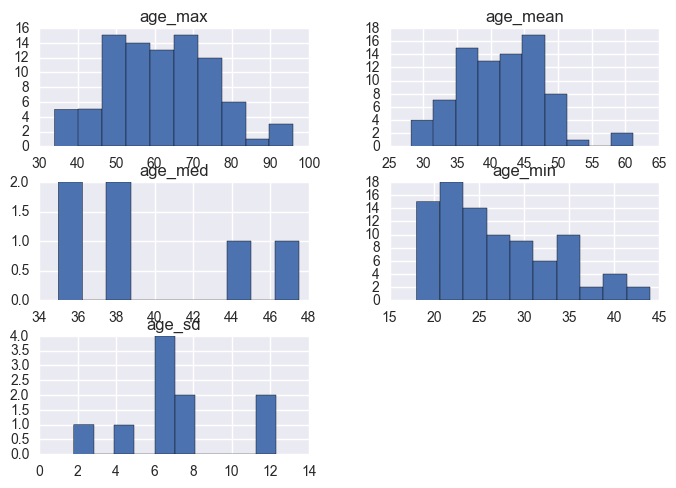

In [6]:
kq3_data[[c for c in kq3_data.columns if c.startswith('age')]].hist();

Breakdown on studies by design.

In [7]:
kq3_data.Design.value_counts()

Retrospective       83
Prospective         38
RCT                 26
Pop based cohort     1
Name: Design, dtype: int64

I will drop the cohort study, since it is the only such representative.

In [8]:
kq3_data = kq3_data[kq3_data.Design!='Pop based cohort']

In [9]:
kq3_data = pd.concat([kq3_data, pd.get_dummies(kq3_data.Design)[['Prospective', 'RCT']]], axis=1)

In [10]:
kq3_data['design_ind'] = kq3_data.Design.replace({'Retrospective':0, 'Prospective':1, 'RCT':2})

In [11]:
kq3_data.loc[kq3_data.Design=='Prospective', ['Population','Tumors']]

,Population,Tumors
Line,,
2.0,10.0,0.0
6.0,91.0,0.0
7.0,75.0,0.0
9.0,24.0,0.0
10.0,25.0,0.0
13.0,80.0,0.0
14.0,136.0,0.0
15.0,11.0,0.0
18.0,25.0,0.0


Following [Pritts et al. (2015)](http://www.ncbi.nlm.nih.gov/pubmed/26283890), I fit a binomial random effects model, such that event probabilities on the logit scale are normally distributed with mean $\mu$ and standard deviation $\sigma$. This distribution describes how the probabilities vary across studies, with the degree of variation described by $\sigma$.

$$\theta_i \sim N(\mu, \sigma^2)$$

the expected value for study $i$ is then inverse-logit transformed, and used as the event probability $\pi_i$ in a binomial model describing the number of observed tumors $t$:

$$\log\left[\frac{\pi_i}{1-\pi_i}\right] = \theta_i$$

$$t_i \sim \text{Bin}(n_i, \pi_i)$$

In [12]:
import theano.tensor as tt
from numpy.ma import masked_values

model_data = kq3_data

k = model_data.shape[0]
tumors = model_data.Tumors.values.astype(int)
n = model_data.Population.values.astype(int)
X = model_data[['Prospective', 'RCT']].values.astype(int)
design = model_data.design_ind.values.astype(int)
age_max_norm = ((model_data.age_max - 60)/10).fillna(0.5).values

poly_terms = 3

def invlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

In [14]:
with pm.Model() as pritts_update:
    
    # Impute missing max ages
    age_max_missing = masked_values(age_max_norm, value=0.5)
    ν = pm.HalfCauchy('ν', 5, testval=1)
    μ_age = pm.Normal('μ_age', 0, 5, testval=0)
    age_max = pm.StudentT('age_max', ν, mu=μ_age, observed=age_max_missing)
    
    # Study random effect
    μ = pm.Normal('μ', 0, sd=100, testval=-3)
    σ = pm.Uniform('σ', 0, 1000, testval=10)
    θ = pm.Normal('θ', μ, sd=σ, shape=k)
    # Design effects
    β = pm.Normal('β', 0, sd=10, shape=2, testval=np.zeros(2))
    # Age effect
    α = pm.Normal('α', 0, sd=10, testval=0)
    
    # Study-specific probabilities
    π = pm.Deterministic('π', invlogit(θ + tt.dot(X,β) + α*age_max))
    
    # Expected probabilities by design
    p_retro_10000 = pm.Deterministic('p_retro_10000', invlogit(μ)*10000)
    p_prosp_10000 = pm.Deterministic('p_prosp_10000', invlogit(μ + β[0])*10000)
    p_rct_10000 = pm.Deterministic('p_rct_10000', invlogit(μ + β[1])*10000)
    
    obs = pm.Binomial('obs', n=n, p=π, observed=tumors)

Applied log-transform to ν and added transformed ν_log_ to model.
Applied interval-transform to σ and added transformed σ_interval_ to model.


In [15]:
with pritts_update:
    trace = pm.sample(2000, njobs=2, random_seed=[20140425, 19700903])

Assigned NUTS to ν_log_
Assigned NUTS to μ_age
Assigned NUTS to age_max_missing
Assigned NUTS to μ
Assigned NUTS to σ_interval_
Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to α
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/multiprocessing/pool.py", line 108, in

KeyboardInterrupt: 

In [49]:
with pm.Model() as pritts_update_noage:
    
    # Study random effect
    μ = pm.Normal('μ', 0, sd=100, testval=-3)
    σ = pm.Uniform('σ', 0, 1000, testval=10)
    θ = pm.Normal('θ', μ, sd=σ, shape=k)
    # Design effects
    β = pm.Normal('β', 0, sd=10, shape=2, testval=np.zeros(2))
    
    # Study-specific probabilities
    π = pm.Deterministic('π', invlogit(θ + tt.dot(X,β)))
    
    # Expected probabilities by design
    p_retro_10000 = pm.Deterministic('p_retro_10000', invlogit(μ)*10000)
    p_prosp_10000 = pm.Deterministic('p_prosp_10000', invlogit(μ + β[0])*10000)
    p_rct_10000 = pm.Deterministic('p_rct_10000', invlogit(μ + β[1])*10000)
    
    obs = pm.Binomial('obs', n=n, p=π, observed=tumors)

Applied interval-transform to σ and added transformed σ_interval_ to model.
/Users/fonnescj/Repositories/pymc3/pymc3/distributions/continuous.py:59: UserWarning: The variable specified for sd has non-positive support for Normal, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [50]:
with pritts_update_noage:
    trace = pm.sample(2000, random_seed=rseeds[0])#, random_seed=[20140425, 19700903])

Assigned NUTS to μ
Assigned NUTS to σ_interval_
Assigned NUTS to θ
Assigned NUTS to β
100%|██████████| 2000/2000 [00:30<00:00, 66.39it/s]


In [13]:
with pm.Model() as pritts_uncond:
    
    # Impute missing max ages
    age_max_missing = masked_values(age_max_norm, value=0.5)
    ν = pm.HalfCauchy('ν', 5, testval=1)
    μ_age = pm.Normal('μ_age', 0, 5, testval=0)
    age_max = pm.StudentT('age_max', ν, mu=μ_age, observed=age_max_missing)
    
    # Study random effect
    μ = pm.Normal('μ', 0, sd=100, testval=-3)
    σ = pm.Uniform('σ', 0, 1000, testval=10)
    θ = pm.Normal('θ', μ, sd=σ, shape=k)
    # Design effects
    β = pm.Normal('β', 0, sd=10, shape=2, testval=np.zeros(2))
    α = pm.Normal('α', 0, sd=10, testval=0)
    
    # Study-specific probabilities
    π = pm.Deterministic('π', invlogit(θ + α*age_max))
    
    p_10000 = pm.Deterministic('p_10000', invlogit(μ)*10000)
    
    obs = pm.Binomial('obs', n=n, p=π, observed=tumors)

Applied log-transform to ν and added transformed ν_log to model.
Applied interval-transform to σ and added transformed σ_interval to model.


In [21]:
with pritts_uncond:
    trace_uncond = pm.sample(2000, random_seed=rseeds[0])#, random_seed=[20140425, 19700903], njobs=2)
#     gp_fit = pm.variational.advi(n=10000)

Assigned NUTS to ν_log_
Assigned NUTS to μ_age
Assigned NUTS to age_max_missing
Assigned NUTS to μ
Assigned NUTS to σ_interval_
Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to α
 [-----------------100%-----------------] 2000 of 2000 complete in 174.7 sec

The following plots are the distribution of samples from the posterior distributions for the expected (population) probability of tumor (`p_update`), the inverse-logit expected probability ($\mu$) and the standard deviation of the probabilities on the inverse-logit scale ($\sigma$).

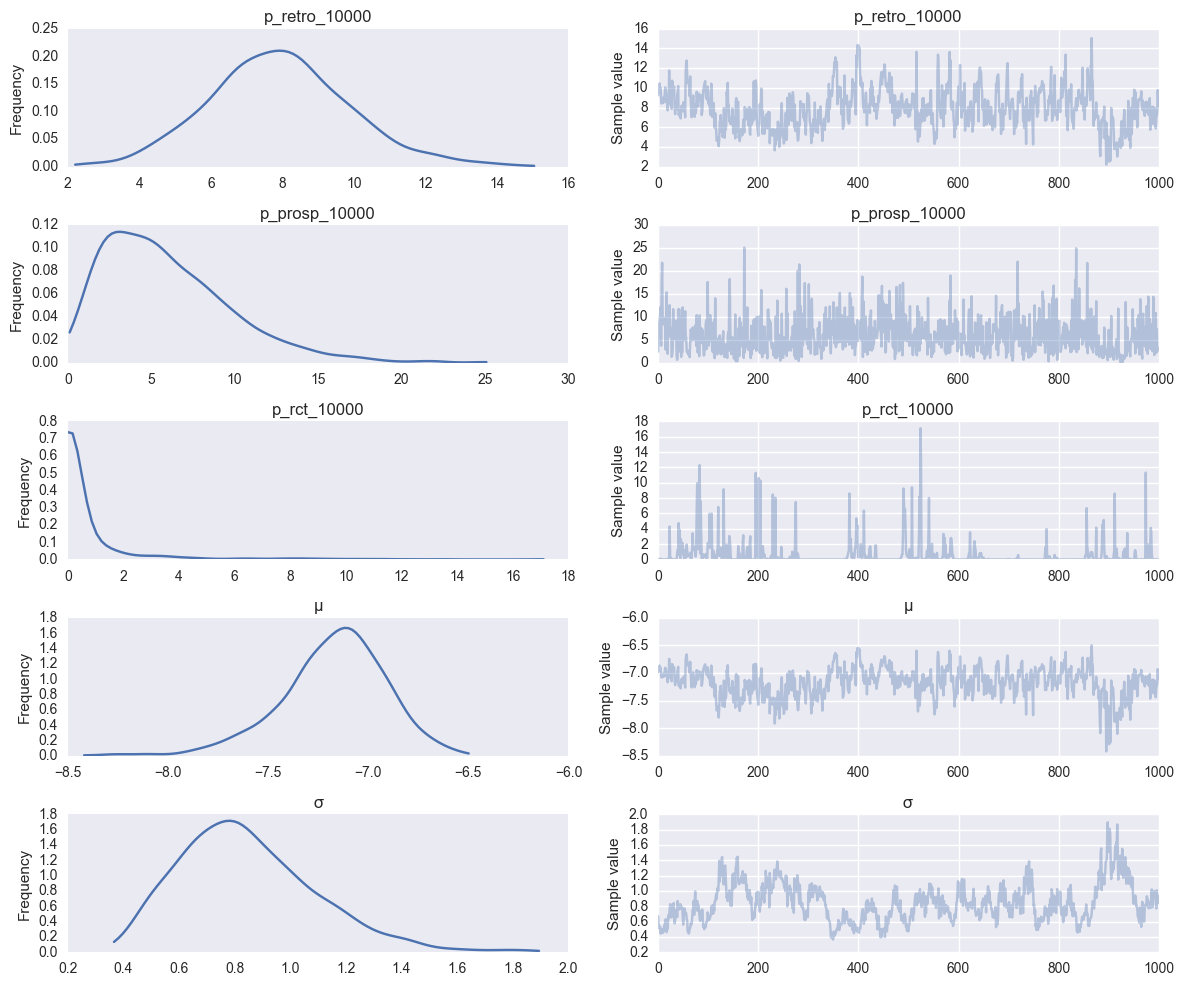

In [51]:
pm.traceplot(trace[1000:], varnames=['p_retro_10000', 'p_prosp_10000', 'p_rct_10000', 
                                    'μ', 'σ']);

Summary statistics from each of the above parameters.

In [52]:
pm.summary(trace[1000:], varnames=['p_retro_10000', 'p_prosp_10000', 'p_rct_10000', 'μ', 'σ'], roundto=4)


p_retro_10000:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  7.9243           1.9669           0.1471           [4.2852, 12.1570]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.2852         6.6371         7.8694         9.1465         12.1570


p_prosp_10000:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.9808           3.8973           0.1653           [0.3619, 13.5602]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.9705         2.9901         5.2146         8.0769         15.5869


p_rct_10000:

  Mean             SD               MC Error         95% HPD inte

By comparison, estimates from Pritts' supplement:

![pritts estimates](pritts_table.png)

In [53]:
p_vars = ['p_retro_10000', 'p_prosp_10000', 'p_rct_10000']
intervals = [pm.stats.hpd(trace[var]) for var in p_vars]

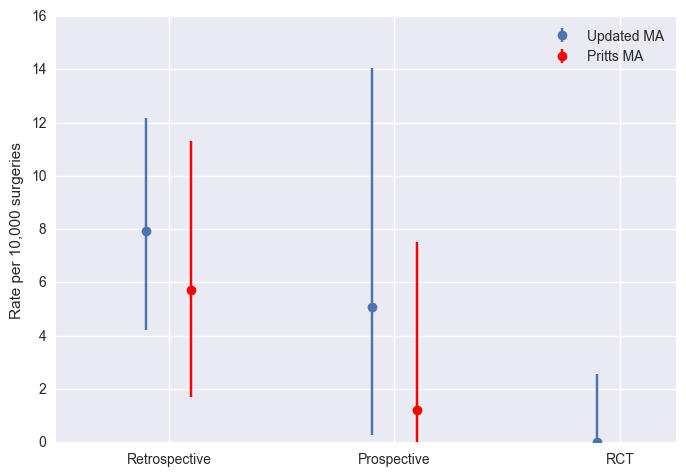

In [54]:
meds = [np.median(trace[var]) for var in p_vars]
upper = [i[1] - m for m,i in zip(meds, intervals)]
lower = [m - i[0] for m,i in zip(meds, intervals)]

plt.errorbar(np.arange(3)-0.1, meds, yerr=[lower, upper], fmt='o', label='Updated MA')
plt.errorbar(np.arange(2)+0.1, [5.7, 1.2], yerr=[[5.7-1.7, 1.2], [11.3 - 5.7,7.5 - 1.2]], color='r', fmt='o', label='Pritts MA')
plt.xticks(range(3), ['Retrospective', 'Prospective', 'RCT'])
plt.ylabel('Rate per 10,000 surgeries')
plt.xlim(-0.5, 2.25)
plt.legend();

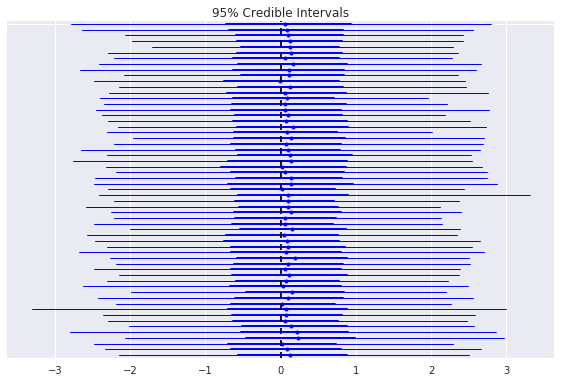

In [30]:
pm.forestplot(trace[1000:], varnames=['age_max_missing'], ylabels=[''])

Pooled estimates

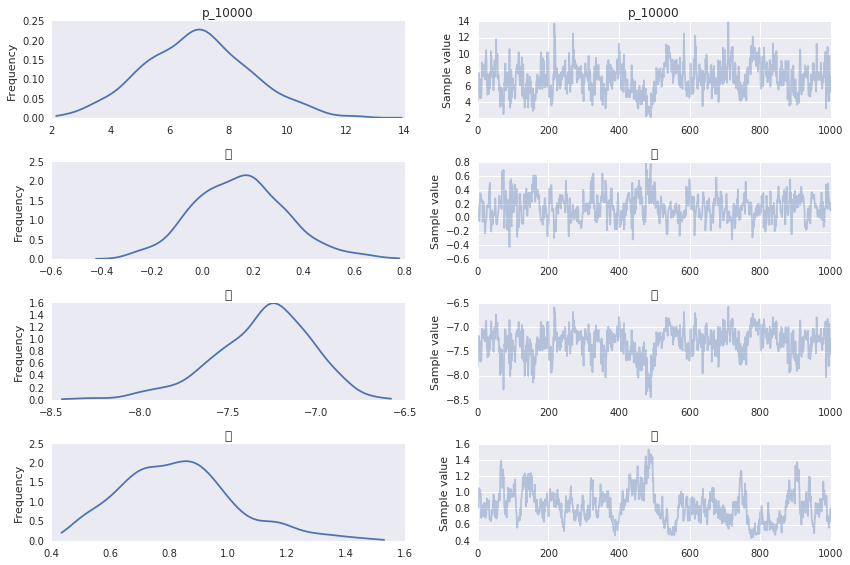

In [24]:
pm.traceplot(trace_uncond[1000:], varnames=['p_10000', 
                                     'α', 'μ', 'σ']);

In [25]:
pm.summary(trace_uncond[1000:], varnames=['p_10000', 
                                     'α', 'μ', 'σ']);


p_10000:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  6.965            1.839            0.131            [3.196, 10.338]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.496          5.677          6.944          8.132          10.769


α:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.149            0.184            0.011            [-0.242, 0.496]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.199         0.020          0.147          0.269          0.548


μ:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

### Goodness of fit

To check how well the model fits the data, I conducted posteior predictive checks. This simulates data from the model for each data point (*i.e.* study) in the meta-analysis, and compares the distribution of these simulated values (here, 500 replicates) with the value of the data itself. If the percentile of the datum is very extreme (either large or small), then it is evidence that the model does not adequately fit the data. The distribution of percentiles in the bottom histogram shows that there is no evidence of lack of fit.

In [31]:
ppc = pm.sample_ppc(trace, model=pritts_update, samples=500)

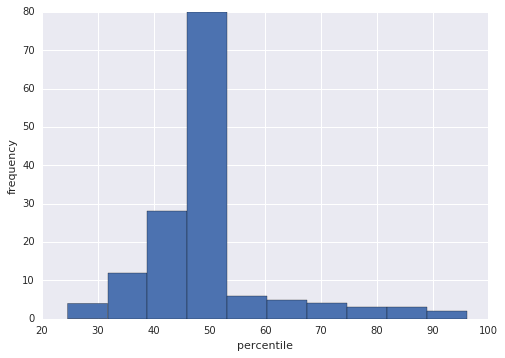

In [32]:
from scipy.stats import percentileofscore
        
p = [percentileofscore(s, o).round(2) for s,o in zip(ppc['obs'].T, tumors)]
        
plt.hist(p)
plt.xlabel('percentile')
plt.ylabel('frequency');